In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 50)

### Loading Kaggle IPL data

In [3]:
df = pd.read_csv("data/df_kaggleAllIpl_preprocessed.csv")
del df['Unnamed: 0']

#### Adding a is_wicket column

In [5]:
df["is_bowler_wicket"] = df["dismissal_kind"].isin(["caught","bowled","lbw","caught and bowled","stumped"]).values.astype(int)

In [28]:
df

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,is_bowler_wicket
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0
1,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0
2,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN,0
3,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0
4,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN,0
5,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,6,S Dhawan,DA Warner,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0
6,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,7,S Dhawan,DA Warner,TS Mills,0,0,0,1,0,0,0,1,1,NaN,NaN,NaN,0
7,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,1,S Dhawan,DA Warner,A Choudhary,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN,0
8,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,2,DA Warner,S Dhawan,A Choudhary,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN,0
9,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,3,DA Warner,S Dhawan,A Choudhary,0,0,0,0,1,0,0,1,1,NaN,NaN,NaN,0


### Player statistics: Season and venue wise

In [68]:
### Number of runs scored
dfp = df.groupby(['season','venue','batting_team','batsman']).sum()["batsman_runs"].reset_index()
dfp = dfp.sort_values(['season', 'venue', 'batting_team','batsman_runs'], ascending=False)
dfp.rename(columns={"batsman":"player","batting_team":"team","batsman_runs":"runs_scored"}, inplace=True)

### Number of balls faced 
df1 = df.copy()
df1 = df1[df1['is_super_over']==0]
df1 = df1[df1['wide_runs']==0]
df1 = df1[df1['noball_runs']==0]
df1 = df1.groupby(['season','venue','batting_team','batsman']).count()["date"].reset_index()
df1.rename(columns={"date":"balls_faced","batting_team":"team","batsman":"player"}, inplace=True)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### Number of innings
df1 = df.copy()
df1 = df1.drop_duplicates(['match_id','batsman'])
df1 = df1.groupby(['season','venue','batting_team','batsman']).count()["date"].reset_index()
df1.rename(columns={"batting_team":"team","date":"num_innings","batsman":"player"}, inplace=True)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### Number of wickets
df1 = df.copy()
df1 = df1.groupby(['season','venue','bowling_team','bowler']).sum()["is_bowler_wicket"].reset_index()
df1.rename(columns={"is_bowler_wicket":"wickets","bowling_team":"team","bowler":"player"}, inplace=True)
df1 = df1.sort_values(['season','wickets'], ascending=False)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### Number of balls bowled 
df1 = df.copy()
df1 = df1[df1['is_super_over']==0]
df1 = df1[df1['wide_runs']==0]
df1 = df1[df1['noball_runs']==0]
df1 = df1.groupby(['season','venue','bowling_team','bowler']).count()["date"].reset_index()
df1.rename(columns={"date":"balls_bowled","bowling_team":"team","bowler":"player"}, inplace=True)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### Number of runs conceded
df1 = df.copy()
df1 = df1[df1['bye_runs']==0]
df1 = df1[df1['legbye_runs']==0]
df1 = df1.groupby(['season','venue','bowling_team','bowler']).sum()["total_runs"].reset_index()
df1.rename(columns={"total_runs":"runs_conceded","bowling_team":"team","bowler":"player"}, inplace=True)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### For players who did not bowl, wickets->0 balls_bowled->0 runs_conceded->0
dfp["wickets"].fillna(0, inplace=True)
dfp["balls_bowled"].fillna(0, inplace=True)
dfp["runs_conceded"].fillna(0, inplace=True)

### For players who did not bat, runs_scored->0, balls_faced->0
dfp["runs_scored"].fillna(0, inplace=True)
dfp["balls_faced"].fillna(0, inplace=True)

dfp

,season,venue,team,player,runs_scored,balls_faced,num_innings,wickets,balls_bowled,runs_conceded
0,2017,Wankhede Stadium,Sunrisers Hyderabad,DA Warner,49,34.0,1,0.0,0.0,0.0
1,2017,Wankhede Stadium,Sunrisers Hyderabad,S Dhawan,48,42.0,1,0.0,0.0,0.0
2,2017,Wankhede Stadium,Sunrisers Hyderabad,BCJ Cutting,20,10.0,1,0.0,12.0,18.0
3,2017,Wankhede Stadium,Sunrisers Hyderabad,DJ Hooda,9,9.0,1,1.0,12.0,18.0
4,2017,Wankhede Stadium,Sunrisers Hyderabad,NV Ojha,9,9.0,1,0.0,0.0,0.0
5,2017,Wankhede Stadium,Sunrisers Hyderabad,Yuvraj Singh,5,7.0,1,0.0,0.0,0.0
6,2017,Wankhede Stadium,Sunrisers Hyderabad,B Kumar,4,3.0,1,3.0,24.0,21.0
7,2017,Wankhede Stadium,Sunrisers Hyderabad,Rashid Khan,2,4.0,1,1.0,24.0,19.0
8,2017,Wankhede Stadium,Sunrisers Hyderabad,V Shankar,1,2.0,1,0.0,0.0,0.0
9,2017,Wankhede Stadium,Royal Challengers Bangalore,AB de Villiers,43,27.0,1,0.0,0.0,0.0


### Derived statistics
#### Batting: Average, strike-rate
#### Bowling:Average, strike-rate, economy rate

In [194]:
### Batting
dfp["bat_avg"] = dfp["runs_scored"]/dfp["num_innings"]
dfp["bat_sr"]  = dfp["runs_scored"]/dfp["balls_faced"]*100
dfp["bat_avgsr"]= dfp["bat_avg"]*dfp["bat_sr"]/100

### Bowling
dfp["bowl_avg"]= dfp["runs_conceded"]/dfp["wickets"]
dfp["bowl_sr"] = dfp["balls_bowled"]/dfp["wickets"]
dfp["bowl_econ"]=dfp["runs_conceded"]/dfp["balls_bowled"]*6
dfp["bowl_avgecon"]=dfp["bowl_avg"]*dfp["bowl_econ"]
dfp

,season,venue,team,player,runs_scored,balls_faced,num_innings,wickets,balls_bowled,runs_conceded,bat_avg,bat_sr,bowl_avg,bowl_sr,bowl_econ,bat_avgsr,bowl_avgecon
0,2017,Wankhede Stadium,Sunrisers Hyderabad,DA Warner,49,34.0,1,0.0,0.0,0.0,49.000000,144.117647,NaN,NaN,NaN,70.617647,NaN
1,2017,Wankhede Stadium,Sunrisers Hyderabad,S Dhawan,48,42.0,1,0.0,0.0,0.0,48.000000,114.285714,NaN,NaN,NaN,54.857143,NaN
2,2017,Wankhede Stadium,Sunrisers Hyderabad,BCJ Cutting,20,10.0,1,0.0,12.0,18.0,20.000000,200.000000,inf,inf,9.000000,40.000000,inf
3,2017,Wankhede Stadium,Sunrisers Hyderabad,DJ Hooda,9,9.0,1,1.0,12.0,18.0,9.000000,100.000000,18.000000,12.000000,9.000000,9.000000,162.000000
4,2017,Wankhede Stadium,Sunrisers Hyderabad,NV Ojha,9,9.0,1,0.0,0.0,0.0,9.000000,100.000000,NaN,NaN,NaN,9.000000,NaN
5,2017,Wankhede Stadium,Sunrisers Hyderabad,Yuvraj Singh,5,7.0,1,0.0,0.0,0.0,5.000000,71.428571,NaN,NaN,NaN,3.571429,NaN
6,2017,Wankhede Stadium,Sunrisers Hyderabad,B Kumar,4,3.0,1,3.0,24.0,21.0,4.000000,133.333333,7.000000,8.000000,5.250000,5.333333,36.750000
7,2017,Wankhede Stadium,Sunrisers Hyderabad,Rashid Khan,2,4.0,1,1.0,24.0,19.0,2.000000,50.000000,19.000000,24.000000,4.750000,1.000000,90.250000
8,2017,Wankhede Stadium,Sunrisers Hyderabad,V Shankar,1,2.0,1,0.0,0.0,0.0,1.000000,50.000000,NaN,NaN,NaN,0.500000,NaN
9,2017,Wankhede Stadium,Royal Challengers Bangalore,AB de Villiers,43,27.0,1,0.0,0.0,0.0,43.000000,159.259259,NaN,NaN,NaN,68.481481,NaN


### Per season venue wise statistics: to make player statistics venue and season (=>pitch) neutral

In [196]:
### Mean bat_avg * bat_sr for each venue during different seasons
dfv = dfp.copy()
dfv = dfv[dfv["runs_scored"]>=20]
dfv = dfv.groupby(["season","venue"]).median()[["bat_avg","bat_sr","bat_avgsr"]].reset_index()

df1 = dfp.copy()
df1 = df1[np.isfinite(df1["bowl_avg"])]
df1 = df1[np.isfinite(df1["bowl_sr"])]
df1 = df1[np.isfinite(df1["bowl_econ"])]
df1 = df1[df1["balls_bowled"]>=12]
df1 = df1.groupby(["season","venue"]).median()[["bowl_avg","bowl_econ","bowl_avgecon"]].reset_index()

dfv = dfv.set_index(["season","venue"]).join(df1.set_index(["season","venue"])).reset_index()
dfv.rename(columns={"bat_avg":"sv_bat_avg","bat_sr":"sv_bat_sr", "bat_avgsr":"sv_bat_avgsr", "bowl_avg":"sv_bowl_avg", "bowl_econ":"sv_bowl_econ","bowl_avgecon":"sv_bowl_avgecon"}, inplace=True)
dfv

,season,venue,sv_bat_avg,sv_bat_sr,sv_bat_avgsr,sv_bowl_avg,sv_bowl_econ,sv_bowl_avgecon
0,2008,Dr DY Patil Sports Academy,29.000000,137.777778,40.080357,21.000000,7.500000,126.041667
1,2008,Eden Gardens,26.000000,121.127503,29.250919,21.166667,7.375000,159.125000
2,2008,Feroz Shah Kotla,30.500000,160.622711,56.227508,19.500000,7.750000,153.125000
3,2008,M Chinnaswamy Stadium,28.000000,116.666667,36.750000,26.000000,7.250000,210.250000
4,2008,"MA Chidambaram Stadium, Chepauk",28.571429,155.161943,48.963068,24.000000,8.750000,192.000000
5,2008,"Punjab Cricket Association Stadium, Mohali",28.166667,146.427177,50.812319,25.619048,8.568182,208.103626
6,2008,"Rajiv Gandhi International Stadium, Uppal",31.000000,138.235294,48.151042,23.250000,8.632867,218.250000
7,2008,Sawai Mansingh Stadium,26.500000,136.835749,40.404818,23.000000,7.708333,175.438849
8,2008,Wankhede Stadium,28.000000,140.000000,37.785714,20.500000,8.450000,188.200000
9,2009,Buffalo Park,32.000000,122.222222,32.975610,20.000000,6.750000,110.250000


### Merge player and venue statistics

In [199]:
dfpv = dfp.set_index(["season","venue"]).join(dfv.set_index(["season","venue"])).reset_index()
dfpv = dfpv[["season","venue","team","player","bat_avg","bat_sr","bat_avgsr","sv_bat_avg","sv_bat_sr","sv_bat_avgsr","bowl_avg","bowl_econ","bowl_avgecon","sv_bowl_avg","sv_bowl_econ","sv_bowl_avgecon"]]
dfpv

,season,venue,team,player,bat_avg,bat_sr,bat_avgsr,sv_bat_avg,sv_bat_sr,sv_bat_avgsr,bowl_avg,bowl_econ,bowl_avgecon,sv_bowl_avg,sv_bowl_econ,sv_bowl_avgecon
0,2008,Dr DY Patil Sports Academy,Rajasthan Royals,SA Asnodkar,33.500000,119.642857,40.080357,29.0,137.777778,40.080357,NaN,NaN,NaN,21.0,7.500000,126.041667
1,2008,Dr DY Patil Sports Academy,Rajasthan Royals,SR Watson,30.000000,153.846154,46.153846,29.0,137.777778,40.080357,18.333333,6.875000,126.041667,21.0,7.500000,126.041667
2,2008,Dr DY Patil Sports Academy,Rajasthan Royals,YK Pathan,28.500000,142.500000,40.612500,29.0,137.777778,40.080357,7.333333,5.500000,40.333333,21.0,7.500000,126.041667
3,2008,Dr DY Patil Sports Academy,Rajasthan Royals,M Kaif,8.000000,100.000000,8.000000,29.0,137.777778,40.080357,NaN,NaN,NaN,21.0,7.500000,126.041667
4,2008,Dr DY Patil Sports Academy,Rajasthan Royals,SK Warne,8.000000,100.000000,8.000000,29.0,137.777778,40.080357,53.000000,8.833333,468.166667,21.0,7.500000,126.041667
5,2008,Dr DY Patil Sports Academy,Rajasthan Royals,Sohail Tanvir,7.500000,115.384615,8.653846,29.0,137.777778,40.080357,53.000000,7.395349,391.953488,21.0,7.500000,126.041667
6,2008,Dr DY Patil Sports Academy,Rajasthan Royals,Kamran Akmal,6.000000,85.714286,5.142857,29.0,137.777778,40.080357,NaN,NaN,NaN,21.0,7.500000,126.041667
7,2008,Dr DY Patil Sports Academy,Rajasthan Royals,GC Smith,5.000000,55.555556,2.777778,29.0,137.777778,40.080357,NaN,NaN,NaN,21.0,7.500000,126.041667
8,2008,Dr DY Patil Sports Academy,Rajasthan Royals,Niraj Patel,2.000000,18.181818,0.363636,29.0,137.777778,40.080357,NaN,NaN,NaN,21.0,7.500000,126.041667
9,2008,Dr DY Patil Sports Academy,Rajasthan Royals,M Rawat,1.000000,20.000000,0.200000,29.0,137.777778,40.080357,NaN,NaN,NaN,21.0,7.500000,126.041667


### Batting metrics:
For each season
    1. WPA
    2. sum_over_venue ( bat_avg * bat_sr - (bat_avg_venueSeason * bat_sr_venueSeason) )
                                   or
       sum_over_venue ( (bat_avg - bat_avg_venueSeason) * (bat_sr - bat_sr_venueSeason) )
    3. (?) Total runs, average, strike rate

### Batting metric 2

In [192]:
dfbat = dfpv.copy()
dfbat["bat_venue"] = dfbat["bat_avgsr"] - dfbat["sv_bat_avgsr"]
dfbat = dfbat.groupby(["season","team","player"]).sum()[["bat_venue"]].reset_index()
#aa = dfbat[(dfbat["venue"]=="M Chinnaswamy Stadium") & (dfbat["season"]==2016)]
aa = dfbat[(dfbat["season"]==2017)]
aa.sort_values("bat_venue", ascending=False)

,season,team,player,bat_venue
1444,2017,Kolkata Knight Riders,CA Lynn,250.893603
1520,2017,Sunrisers Hyderabad,DA Warner,120.810152
1450,2017,Kolkata Knight Riders,MK Pandey,79.836636
1423,2017,Gujarat Lions,SK Raina,63.103959
1501,2017,Royal Challengers Bangalore,CH Gayle,59.777547
1493,2017,Rising Pune Supergiant,RA Tripathi,51.881516
1402,2017,Delhi Daredevils,SS Iyer,49.125592
1522,2017,Sunrisers Hyderabad,KS Williamson,42.954315
1464,2017,Mumbai Indians,JC Buttler,41.707159
1499,2017,Royal Challengers Bangalore,AB de Villiers,36.403145


### Bowling metrics:

    1. WPA
    2. sum_over_venue ( bowl_avg * bowl_econ - (bowl_avg_venueSeason * bowl_econ_venueSeason) )
                                   or
       sum_over_venue( (bowl_avg - bowl_avg_venueSeason) * (bowl_econ - bowl_econ_venueSeason) )       
    3. Wickets weighted by batsman's metric.
    4. (?) Total wickets, average, economy, strike rate

### Bowling metric 2

In [202]:
dfball = dfpv.copy()
dfball["ball_venue"] = dfball["bowl_avgecon"] - dfball["sv_bowl_avgecon"]
dfball = dfball.groupby(["season","team","player"]).sum()[["ball_venue"]].reset_index()
aa = dfball[(dfball["season"]==2017)]
aa.sort_values("ball_venue", ascending=False)

,season,team,player,ball_venue
1388,2017,Delhi Daredevils,A Mishra,inf
1439,2017,Kings XI Punjab,Swapnil Singh,inf
1442,2017,Kolkata Knight Riders,AS Rajpoot,inf
1443,2017,Kolkata Knight Riders,C de Grandhomme,inf
1456,2017,Kolkata Knight Riders,SP Narine,inf
1457,2017,Kolkata Knight Riders,Shakib Al Hasan,inf
1460,2017,Kolkata Knight Riders,YK Pathan,inf
1389,2017,Delhi Daredevils,AD Mathews,inf
1463,2017,Mumbai Indians,Harbhajan Singh,inf
1466,2017,Mumbai Indians,KA Pollard,inf


In [93]:
df['venue'].unique()

array(['Rajiv Gandhi International Stadium, Uppal',
       'Maharashtra Cricket Association Stadium',
       'Saurashtra Cricket Association Stadium', 'Holkar Cricket Stadium',
       'M Chinnaswamy Stadium', 'Wankhede Stadium', 'Eden Gardens',
       'Feroz Shah Kotla',
       'Punjab Cricket Association IS Bindra Stadium, Mohali',
       'Green Park', 'Punjab Cricket Association Stadium, Mohali',
       'Sawai Mansingh Stadium', 'MA Chidambaram Stadium, Chepauk',
       'Dr DY Patil Sports Academy', 'Newlands', "St George's Park",
       'Kingsmead', 'SuperSport Park', 'Buffalo Park',
       'New Wanderers Stadium', 'De Beers Diamond Oval', 'OUTsurance Oval',
       'Brabourne Stadium', 'Sardar Patel Stadium, Motera',
       'Barabati Stadium', 'Vidarbha Cricket Association Stadium, Jamtha',
       'Himachal Pradesh Cricket Association Stadium', 'Nehru Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Subrata Roy Sahara Stadium',
       'Shaheed Veer Nar

In [100]:
dfp

,season,venue,team,player,runs_scored,balls_faced,num_innings,wickets,balls_bowled,runs_conceded,bat_avg,bat_sr,bowl_avg,bowl_sr
0,2017,Wankhede Stadium,Sunrisers Hyderabad,DA Warner,49,34.0,1,0.0,0.0,0.0,49.000000,144.117647,NaN,NaN
1,2017,Wankhede Stadium,Sunrisers Hyderabad,S Dhawan,48,42.0,1,0.0,0.0,0.0,48.000000,114.285714,NaN,NaN
2,2017,Wankhede Stadium,Sunrisers Hyderabad,BCJ Cutting,20,10.0,1,0.0,12.0,18.0,20.000000,200.000000,inf,inf
3,2017,Wankhede Stadium,Sunrisers Hyderabad,DJ Hooda,9,9.0,1,1.0,12.0,18.0,9.000000,100.000000,18.000000,12.000000
4,2017,Wankhede Stadium,Sunrisers Hyderabad,NV Ojha,9,9.0,1,0.0,0.0,0.0,9.000000,100.000000,NaN,NaN
5,2017,Wankhede Stadium,Sunrisers Hyderabad,Yuvraj Singh,5,7.0,1,0.0,0.0,0.0,5.000000,71.428571,NaN,NaN
6,2017,Wankhede Stadium,Sunrisers Hyderabad,B Kumar,4,3.0,1,3.0,24.0,21.0,4.000000,133.333333,7.000000,8.000000
7,2017,Wankhede Stadium,Sunrisers Hyderabad,Rashid Khan,2,4.0,1,1.0,24.0,19.0,2.000000,50.000000,19.000000,24.000000
8,2017,Wankhede Stadium,Sunrisers Hyderabad,V Shankar,1,2.0,1,0.0,0.0,0.0,1.000000,50.000000,NaN,NaN
9,2017,Wankhede Stadium,Royal Challengers Bangalore,AB de Villiers,43,27.0,1,0.0,0.0,0.0,43.000000,159.259259,NaN,NaN


In [118]:
df1 = dfp.copy()
df1 = df1[ (df1['runs_scored']>=20) & (df1['season']==2017)]
df1["eff_sr"] = df1["runs_scored"] / df1["num_innings"] * df1["bat_sr"] /100
df1[df1['venue']=="M Chinnaswamy Stadium"]

,season,venue,team,player,runs_scored,balls_faced,num_innings,wickets,balls_bowled,runs_conceded,bat_avg,bat_sr,bowl_avg,bowl_sr,eff_sr
310,2017,M Chinnaswamy Stadium,Sunrisers Hyderabad,DA Warner,37,35.0,1,0.0,0.0,0.0,37.000000,105.714286,NaN,NaN,39.114286
311,2017,M Chinnaswamy Stadium,Sunrisers Hyderabad,KS Williamson,24,26.0,1,0.0,0.0,0.0,24.000000,92.307692,NaN,NaN,22.153846
312,2017,M Chinnaswamy Stadium,Sunrisers Hyderabad,V Shankar,22,17.0,1,0.0,0.0,0.0,22.000000,129.411765,NaN,NaN,28.470588
318,2017,M Chinnaswamy Stadium,Royal Challengers Bangalore,KM Jadhav,141,99.0,6,0.0,0.0,0.0,23.500000,142.424242,NaN,NaN,33.469697
319,2017,M Chinnaswamy Stadium,Royal Challengers Bangalore,Mandeep Singh,118,111.0,6,0.0,0.0,0.0,19.666667,106.306306,NaN,NaN,20.906907
320,2017,M Chinnaswamy Stadium,Royal Challengers Bangalore,V Kohli,111,94.0,5,0.0,0.0,0.0,22.200000,118.085106,NaN,NaN,26.214894
321,2017,M Chinnaswamy Stadium,Royal Challengers Bangalore,P Negi,91,73.0,6,7.0,85.0,109.0,15.166667,124.657534,15.571429,12.142857,18.906393
322,2017,M Chinnaswamy Stadium,Royal Challengers Bangalore,TM Head,75,48.0,2,0.0,12.0,22.0,37.500000,156.250000,inf,inf,58.593750
323,2017,M Chinnaswamy Stadium,Royal Challengers Bangalore,AB de Villiers,73,76.0,5,0.0,0.0,0.0,14.600000,96.052632,NaN,NaN,14.023684
324,2017,M Chinnaswamy Stadium,Royal Challengers Bangalore,SR Watson,41,48.0,3,3.0,72.0,108.0,13.666667,85.416667,36.000000,24.000000,11.673611


In [121]:
df1 = dfp.copy()
df1 = df1[ (df1['runs_scored']>=20) & (df1['season']==2017) ]
df1["eff_sr"] = df1["runs_scored"] / df1["num_innings"] * df1["bat_sr"] /100
#df1["eff_sr"] = df1["bat_avg"] * df1["bat_sr"] /100
aa = df1.groupby('venue').mean()["eff_sr"].reset_index()
aa.sort_values('eff_sr',ascending=False)

,venue,eff_sr
3,Holkar Cricket Stadium,69.085306
6,"Punjab Cricket Association IS Bindra Stadium, ...",67.001351
8,Saurashtra Cricket Association Stadium,64.968406
2,Green Park,62.820581
5,Maharashtra Cricket Association Stadium,60.057659
9,Wankhede Stadium,54.618105
1,Feroz Shah Kotla,54.149876
7,"Rajiv Gandhi International Stadium, Uppal",50.662143
0,Eden Gardens,49.713175
4,M Chinnaswamy Stadium,38.214353


In [105]:
df1 = dfp.copy()
df1 = df1[df1['runs_scored']>=20]
df1["eff_avg"] = df1["runs_scored"] * df1["bat_avg"] /100
aa = df1.groupby('venue').mean()["eff_avg"].reset_index()
aa.sort_values('eff_avg',ascending=False)

,venue,eff_avg
21,"Punjab Cricket Association IS Bindra Stadium, ...",27.349939
15,"MA Chidambaram Stadium, Chepauk",26.135185
14,M Chinnaswamy Stadium,25.907410
16,Maharashtra Cricket Association Stadium,24.793203
25,Saurashtra Cricket Association Stadium,24.450016
11,Holkar Cricket Stadium,24.205200
10,Himachal Pradesh Cricket Association Stadium,24.161789
22,"Punjab Cricket Association Stadium, Mohali",23.580989
32,SuperSport Park,23.579082
23,"Rajiv Gandhi International Stadium, Uppal",23.133643


(array([ 53.,  10.,   4.,   0.,   2.,   2.,   0.,   0.,   1.,   1.]),
 array([   0.        ,   38.01610738,   76.03221477,  114.04832215,
         152.06442953,  190.08053691,  228.0966443 ,  266.11275168,
         304.12885906,  342.14496644,  380.16107383]),
 <a list of 10 Patch objects>)

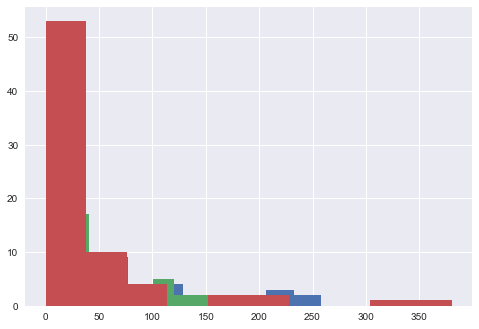

In [95]:
df1 = dfp.copy()
df1["eff_sr"] = df1["runs_scored"] * df1["bat_sr"] /100
df1
aa = df1[ (df1['season']==2017) & (df1['venue']=="Wankhede Stadium")]
plt.hist(aa['eff_sr'])
aa = df1[ (df1['season']==2017) & (df1['venue']=="M Chinnaswamy Stadium")]
plt.hist(aa['eff_sr'])
aa = df1[ (df1['season']==2017) & (df1['venue']=="Eden Gardens")]
plt.hist(aa['eff_sr'])

### Average runs in different venues for each season

In [7]:
df1 = df.groupby(['venue','season','match_id','inning']).sum()["total_runs"].reset_index()


,venue,season,match_id,inning,total_runs
0,Barabati Stadium,2010,186,1,170
1,Barabati Stadium,2010,186,2,164
2,Barabati Stadium,2010,189,1,171
3,Barabati Stadium,2010,189,2,161
4,Barabati Stadium,2012,337,1,126
5,Barabati Stadium,2012,337,2,127
6,Barabati Stadium,2012,348,1,186
7,Barabati Stadium,2012,348,2,173
8,Barabati Stadium,2014,486,1,231
9,Barabati Stadium,2014,486,2,187
